In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import random
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.font_manager as fm

[(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]
plt.rcParams['font.family'] = 'Nanum'

In [3]:
df_01 = pd.read_csv('../bigdata/LPOINT_BIG_COMP/LPOINT_BIG_COMP_01_DEMO.csv')
df_02 = pd.read_csv('../bigdata/LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv')
df_03 = pd.read_csv('../bigdata/LPOINT_BIG_COMP/LPOINT_BIG_COMP_03_COP_U.csv')
df_04 = pd.read_csv('../bigdata/LPOINT_BIG_COMP/LPOINT_BIG_COMP_04_PD_CLAC.csv')
df_05 = pd.read_csv('../bigdata/LPOINT_BIG_COMP/LPOINT_BIG_COMP_05_BR.csv')
df_06 = pd.read_csv('../bigdata/LPOINT_BIG_COMP/LPOINT_BIG_COMP_06_LPAY.csv')

In [35]:
df_01

,cust,ma_fem_dv,ages,zon_hlv
0,M000034966,여성,40대,Z07
1,M000059535,여성,30대,Z12
2,M000136117,여성,30대,Z11
3,M000201112,여성,50대,Z17
4,M000225114,여성,40대,Z17
...,...,...,...,...
29908,M999708287,여성,40대,Z10
29909,M999770689,여성,30대,Z16
29910,M999849895,여성,20대,Z04
29911,M999926092,남성,30대,Z08


In [44]:
df_03[df_03['buy_am'] < 10]

,cust,rct_no,cop_c,br_c,chnl_dv,de_dt,vst_dt,de_hr,buy_am
83764,M428228836,21092923E011529400,E01,E010001,1,20210929,20210929,23,2
105916,M161058219,21022119E011025418,E01,E010001,1,20210221,20210221,19,2
131813,M932721973,21061115C022916363,C02,C020002,1,20210611,20210611,15,1
205736,M977620139,21031614E013123310,E01,E010001,1,20210316,20210316,14,2


In [45]:
df_03[df_03['cust'] == 'M977620139']

,cust,rct_no,cop_c,br_c,chnl_dv,de_dt,vst_dt,de_hr,buy_am
81547,M977620139,21103002E011636386,E01,E010001,1,20211030,20211030,2,30450
81548,M977620139,21110108E012076945,E01,E010001,1,20211101,20211101,8,7929
81549,M977620139,21110117E012412674,E01,E010001,1,20211101,20211101,17,11570
81550,M977620139,21110209E015451197,E01,E010001,1,20211102,20211102,9,534
81551,M977620139,21060715E010017816,E01,E010001,1,20210607,20210607,15,1335
81552,M977620139,21110810E012559541,E01,E010001,1,20211108,20211108,10,51
81553,M977620139,21011218E012046720,E01,E010001,1,20210112,20210112,18,4389
81554,M977620139,21071320E011923199,E01,E010001,1,20210713,20210713,20,22060
81555,M977620139,21112921E013010430,E01,E010001,1,20211129,20211129,21,11090
81556,M977620139,21072823E015623890,E01,E010001,1,20210728,20210728,23,232


In [4]:
df_03

,cust,rct_no,cop_c,br_c,chnl_dv,de_dt,vst_dt,de_hr,buy_am
0,M839993508,21102612B015763935,B01,B010012,1,20211026,20211026,12,60000
1,M839993508,21110610B014219744,B01,B010012,1,20211106,20211106,10,17100
2,M839993508,21021112B013419710,B01,B010012,1,20210211,20210211,12,136500
3,M839993508,21092010B012637545,B01,B010012,1,20210920,20210920,10,34200
4,M839993508,21101009D015920171,D01,D010614,1,20211010,20211010,9,2500
...,...,...,...,...,...,...,...,...,...
248299,M058650684,21111614C021426818,C02,C020002,1,20211116,20211116,14,2000
248300,M058650684,21111619C023223432,C02,C020002,1,20211116,20211116,19,26900
248301,M014154595,21121209C015324520,C01,C010087,2,20211212,20211212,9,2000
248302,M510878172,21112719C013369102,C01,C010007,2,20211127,20211127,19,6000


In [33]:
df_03['buy_am'].describe()

count    2.483040e+05
mean     2.013066e+04
std      2.430121e+05
min      1.000000e+00
25%      5.000000e+03
50%      9.000000e+03
75%      1.580000e+04
max      7.009200e+07
Name: buy_am, dtype: float64

In [29]:
df_03['buy_am'].max()

70092000

In [5]:
df_02 = df_02[df_02['chnl_dv'] == 1]

In [6]:
df_02.drop(columns=['buy_am', 'de_dt', 'rct_no', 'chnl_dv'], axis=1, inplace=True)

In [109]:
df_merge_02_04 = pd.merge(df_02, df_04, on='pd_c')
df_merge_02_04 

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1,402,남성의류,남성의류상의
1,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,402,남성의류,남성의류상의
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,402,남성의류,남성의류상의
3,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1,402,남성의류,남성의류상의
4,M506355556,A01000107137,1,A01,A010032,PD0290,20210101,15,199000.0,1,402,남성의류,남성의류상의
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381738,M696533418,E06045892016,2,A06,NaN,PD0520,20211115,0,9900.0,1,1454,생활/렌탈서비스,렌탈서비스
4381739,M696533418,E06045892016,2,A06,NaN,PD0520,20211115,0,9900.0,1,1454,생활/렌탈서비스,렌탈서비스
4381740,M111856694,E06045887405,2,A06,NaN,PD0520,20211118,0,100.0,1,1454,생활/렌탈서비스,렌탈서비스
4381741,M001808316,E06045891296,2,A06,NaN,PD0520,20211118,0,100.0,1,1454,생활/렌탈서비스,렌탈서비스


### 상품 상위 5개 추출

In [7]:
def frequency_product(cust, df_merge_02_04):
    person_id = cust
    pd_c = df_merge_02_04[df_merge_02_04['cust'] == person_id][['clac_hlv_nm', 'buy_ct']]
    pd_c = pd_c.groupby('clac_hlv_nm')['buy_ct'].sum().reset_index()
    pd_c = pd_c.sort_values(by='buy_ct', ascending=False, ignore_index=True)
    freq_product = []
    for i in range(5):
        try:
            freq_product.append(pd_c['clac_hlv_nm'][i])

        except: KeyError
            
    return freq_product

In [8]:
frequency_product('M430112881', df_merge_02_04)

['채소', '냉장식품', '수산물', '유제품', '음료']

In [ ]:
df_01['freq_product'] = df_01.apply(lambda x : frequency_product(x['cust'], df_merge_02_04), axis=1)

### 평점 변환

In [8]:
def convert_rating(cust, clac_hlv_nm, df):
    
    person_id = cust    
    try:
        pd_c = df[df['cust'] == cust][['clac_hlv_nm', 'buy_ct']]
        pd_c = pd_c.groupby('clac_hlv_nm')['buy_ct'].sum().reset_index()
        pd_c = pd_c.sort_values(by='buy_ct', ascending=False, ignore_index=True)

        pd_c['buy_ct'] = (pd_c['buy_ct'] - pd_c['buy_ct'].min()) / (pd_c['buy_ct'].max() - pd_c['buy_ct'].min())
        pd_c['buy_ct'][0] = random.uniform(0.85, 1.01) 
        pd_c['buy_ct'] = np.round(pd_c['buy_ct'], 2) * 10

        res = float(pd_c[pd_c['clac_hlv_nm'] == clac_hlv_nm]['buy_ct'])
        
    except: ValueError
        
    return res

In [11]:
res = convert_rating(df_merge_02_04['cust'][10], df_merge_02_04['clac_hlv_nm'][10], df_merge_02_04)
res

3.8

In [ ]:
df_merge_02_04['ratings'] = df_merge_02_04.apply(lambda x : convert_rating(x['cust'], x['clac_hlv_nm'], df_merge_02_04), axis=1)

### 멀티프로세싱

In [1]:
from preprocessing import parallel_dataframe

In [18]:
import multiprocessing as mp

num_cores = mp.cpu_count()

def parallel_dataframe(df, func, cores):
    global num_cores
    df_split = np.array_split(df, cores)
    pool = mp.Pool(cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    
    return df

In [19]:
tqdm.pandas()
def make_ratings(data):
    data['ratings'] = data.progress_apply(lambda x : convert_rating(x['cust'], x['clac_hlv_nm'], data), axis=1)
    return data

In [21]:
df = parallel_dataframe(df_merge_02_04, make_ratings)

100%|████████████████████████████████| 658874/658874 [10:28:50<00:00, 17.46it/s]


In [22]:
df.to_csv('df_merge_02_04_ratings.csv')

In [24]:
df['ratings'].isna().sum()

13256

In [27]:
df_test = df[df['ratings'].isna()]
df_test

,cust,cop_c,br_c,pd_c,de_hr,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,ratings
282,M260927455,A01,A010021,PD0290,15,1,남성티셔츠,남성의류,남성의류상의,NaN
1342,M403286666,A01,A010024,PD0290,16,1,남성티셔츠,남성의류,남성의류상의,NaN
1346,M403286666,A01,A010024,PD0290,17,1,남성티셔츠,남성의류,남성의류상의,NaN
2519,M560023501,A01,A010002,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,NaN
3040,M614062136,A01,A010045,PD0290,14,1,남성티셔츠,남성의류,남성의류상의,NaN
...,...,...,...,...,...,...,...,...,...,...
3952965,M081494913,A05,A050130,PD0552,11,1,전기프라이팬,생활/주방가전,주방가전,NaN
3952974,M784453498,A05,A050238,PD0990,17,1,TV장식장/거치대,영상/음향가전,TV,NaN
3953035,M224574767,A05,A050274,PD1004,19,1,컴팩트,영상/음향가전,카메라/캠코더,NaN
3953093,M518148689,A05,A050267,PD0998,15,1,CDP/카세트,영상/음향가전,오디오,NaN


In [43]:
df.dropna(inplace=True)

In [44]:
df_others = parallel_dataframe(df_test, make_ratings)
df_others

100%|██████████████████████████████████████| 2210/2210 [00:10<00:00, 211.69it/s]


,cust,cop_c,br_c,pd_c,de_hr,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,ratings
282,M260927455,A01,A010021,PD0290,15,1,남성티셔츠,남성의류,남성의류상의,9.1
1342,M403286666,A01,A010024,PD0290,16,1,남성티셔츠,남성의류,남성의류상의,8.6
1346,M403286666,A01,A010024,PD0290,17,1,남성티셔츠,남성의류,남성의류상의,9.5
2519,M560023501,A01,A010002,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,9.2
3040,M614062136,A01,A010045,PD0290,14,1,남성티셔츠,남성의류,남성의류상의,9.7
...,...,...,...,...,...,...,...,...,...,...
3952965,M081494913,A05,A050130,PD0552,11,1,전기프라이팬,생활/주방가전,주방가전,9.8
3952974,M784453498,A05,A050238,PD0990,17,1,TV장식장/거치대,영상/음향가전,TV,8.8
3953035,M224574767,A05,A050274,PD1004,19,1,컴팩트,영상/음향가전,카메라/캠코더,9.3
3953093,M518148689,A05,A050267,PD0998,15,1,CDP/카세트,영상/음향가전,오디오,9.1


In [45]:
df_others['ratings'].isna().sum()

4083

In [47]:
df = pd.concat([df, df_others])
df.dropna(inplace=True)

In [73]:
df

,cust,cop_c,br_c,pd_c,de_hr,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,ratings
0,11214,A01,38,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0
1,11214,A01,38,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0
2,11214,A01,38,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0
3,11214,A01,38,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0
4,13236,A01,31,PD0290,15,1,남성티셔츠,남성의류,남성의류상의,9.7
...,...,...,...,...,...,...,...,...,...,...
3952940,2972,A05,6707,PD0552,16,1,전기프라이팬,생활/주방가전,주방가전,9.0
3952965,2132,A05,6443,PD0552,11,1,전기프라이팬,생활/주방가전,주방가전,9.8
3952974,20503,A05,6551,PD0990,17,1,TV장식장/거치대,영상/음향가전,TV,8.8
3953035,5880,A05,6587,PD1004,19,1,컴팩트,영상/음향가전,카메라/캠코더,9.3


In [ ]:
df.to_csv('fill_isna_df.csv')

In [9]:
df_04

,pd_c,pd_nm,clac_hlv_nm,clac_mcls_nm
0,PD0001,소파,가구,거실가구
1,PD0002,스툴/리빙의자,가구,거실가구
2,PD0003,탁자,가구,거실가구
3,PD0004,장식장/진열장,가구,거실가구
4,PD0005,기타가구,가구,기타가구
...,...,...,...,...
1928,PD1929,여성향수,화장품/뷰티케어,향수
1929,PD1930,남성향수,화장품/뷰티케어,향수
1930,PD1931,남녀공용향수,화장품/뷰티케어,향수
1931,PD1932,남성향수세트,화장품/뷰티케어,향수


In [4]:
df = pd.read_csv('../bigdata/df_merge_02_04_ratings.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df

,cust,cop_c,br_c,pd_c,de_hr,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,ratings
0,M430112881,A01,A010039,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0
1,M430112881,A01,A010039,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0
2,M430112881,A01,A010039,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0
3,M430112881,A01,A010039,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0
4,M506355556,A01,A010032,PD0290,15,1,남성티셔츠,남성의류,남성의류상의,9.7
...,...,...,...,...,...,...,...,...,...,...
3953237,M033482606,A05,A050003,PD0075,20,1,혈당계/혈압계,건강용품,건강측정용품,1.1
3953238,M489266563,A05,A050426,PD1221,15,1,청소기/광택기,자동차용품,세차용품,0.0
3953239,M296090374,A05,A050260,PD0543,11,1,이발기,생활/주방가전,이미용가전,0.4
3953240,M560002381,A05,A050039,PD0543,12,1,이발기,생활/주방가전,이미용가전,0.0


In [5]:
df['de_dt'] = df_02['de_dt'].astype('int64')
df['de_dt'] = df['de_dt'].astype('str')
df.dropna(axis=0, inplace=True)
df

,cust,cop_c,br_c,pd_c,de_hr,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,ratings,de_dt
0,M430112881,A01,A010039,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0,20210101
1,M430112881,A01,A010039,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0,20210101
2,M430112881,A01,A010039,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0,20210101
3,M430112881,A01,A010039,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0,20210101
4,M506355556,A01,A010032,PD0290,15,1,남성티셔츠,남성의류,남성의류상의,9.7,20210101
...,...,...,...,...,...,...,...,...,...,...,...
3953237,M033482606,A05,A050003,PD0075,20,1,혈당계/혈압계,건강용품,건강측정용품,1.1,20211218
3953238,M489266563,A05,A050426,PD1221,15,1,청소기/광택기,자동차용품,세차용품,0.0,20211218
3953239,M296090374,A05,A050260,PD0543,11,1,이발기,생활/주방가전,이미용가전,0.4,20211218
3953240,M560002381,A05,A050039,PD0543,12,1,이발기,생활/주방가전,이미용가전,0.0,20211218


In [6]:
df_02 = df_02[['cust', 'pd_c', 'de_dt']]
df_02

,cust,pd_c,de_dt
0,M430112881,PD0290,20210101
1,M646853852,PD1369,20210101
2,M430112881,PD0290,20210101
3,M430112881,PD0290,20210101
4,M430112881,PD0290,20210101
...,...,...,...
4381738,M533286446,PD0507,20211231
4381739,M533286446,PD0507,20211231
4381740,M533286446,PD0507,20211231
4381741,M533286446,PD0507,20211231


In [7]:
weather_df = pd.read_csv('../bigdata/weather.csv', encoding='euc-kr', skiprows=6)
weather_df['날짜'] = weather_df['날짜'].astype('str')
weather_df['날짜'] = weather_df['날짜'].str.replace(pat=r'-',repl=r'',regex=True)
weather_df['날짜'].astype('int64')

weather_df = weather_df.rename(columns={'날짜' : 'de_dt', '평균기온(℃)': '평균기온'})
weather_df.drop(columns=['지점', '최저기온(℃)', '최고기온(℃)'], axis=1, inplace=True)
weather_df

,de_dt,평균기온
0,20210101,-3.4
1,20210102,-2.8
2,20210103,-3.3
3,20210104,-2.0
4,20210105,-2.2
...,...,...
360,20211227,-4.6
361,20211228,0.0
362,20211229,2.5
363,20211230,-0.7


In [8]:
df = pd.merge(df, weather_df, on='de_dt')
df

,cust,cop_c,br_c,pd_c,de_hr,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,ratings,de_dt,평균기온
0,M430112881,A01,A010039,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0,20210101,-3.4
1,M430112881,A01,A010039,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0,20210101,-3.4
2,M430112881,A01,A010039,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0,20210101,-3.4
3,M430112881,A01,A010039,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0,20210101,-3.4
4,M506355556,A01,A010032,PD0290,15,1,남성티셔츠,남성의류,남성의류상의,9.7,20210101,-3.4
...,...,...,...,...,...,...,...,...,...,...,...,...
3939981,M148435735,A02,A020055,PD0729,16,1,문어,수산물,연체류,9.5,20211231,-3.9
3939982,M852672532,A02,A020012,PD0729,22,1,문어,수산물,연체류,8.9,20211231,-3.9
3939983,M852672532,A02,A020012,PD0729,15,1,문어,수산물,연체류,8.9,20211231,-3.9
3939984,M950449432,A02,A020044,PD0729,18,1,문어,수산물,연체류,3.5,20211231,-3.9


In [3]:
df.to_csv('weather_deep.csv')

NameError: name 'df' is not defined

In [23]:
df = pd.read_csv('../dataset/weather_deep.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df

,cust,cop_c,br_c,pd_c,de_hr,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,ratings,de_dt,평균기온
0,M430112881,A01,A010039,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0,20210101,-3.4
1,M430112881,A01,A010039,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0,20210101,-3.4
2,M430112881,A01,A010039,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0,20210101,-3.4
3,M430112881,A01,A010039,PD0290,10,1,남성티셔츠,남성의류,남성의류상의,5.0,20210101,-3.4
4,M506355556,A01,A010032,PD0290,15,1,남성티셔츠,남성의류,남성의류상의,9.7,20210101,-3.4
...,...,...,...,...,...,...,...,...,...,...,...,...
3939981,M148435735,A02,A020055,PD0729,16,1,문어,수산물,연체류,9.5,20211231,-3.9
3939982,M852672532,A02,A020012,PD0729,22,1,문어,수산물,연체류,8.9,20211231,-3.9
3939983,M852672532,A02,A020012,PD0729,15,1,문어,수산물,연체류,8.9,20211231,-3.9
3939984,M950449432,A02,A020044,PD0729,18,1,문어,수산물,연체류,3.5,20211231,-3.9


### LabelEncoder
- cust, br_c

In [32]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

columns = ['cust', 'pd_nm', '평균기온']
count = 0
for i in columns:
    globals()[f'encoder_{count}'] = LabelEncoder()
    df[i] = globals()[f'encoder_{count}'].fit_transform(df[i])
    count += 1    

## Deeplearning
- dot 기반

### DATA, PRODUCT 데이터 나누기

In [33]:
data = df[['cust', 'pd_nm', 'de_dt', '평균기온', 'ratings']]
data

,cust,pd_nm,de_dt,평균기온,ratings
0,11214,391,20210101,15,5.0
1,11214,391,20210101,15,5.0
2,11214,391,20210101,15,5.0
3,11214,391,20210101,15,5.0
4,13236,391,20210101,15,9.7
...,...,...,...,...,...
3939981,3886,608,20211231,12,9.5
3939982,22268,608,20211231,12,8.9
3939983,22268,608,20211231,12,8.9
3939984,24809,608,20211231,12,3.5


In [64]:
product = df_04
product

,pd_c,pd_nm,clac_hlv_nm,clac_mcls_nm
0,PD0001,869,가구,거실가구
1,PD0002,939,가구,거실가구
2,PD0003,1706,가구,거실가구
3,PD0004,1472,가구,거실가구
4,PD0005,176,가구,기타가구
...,...,...,...,...
1928,PD1929,1190,화장품/뷰티케어,향수
1929,PD1930,408,화장품/뷰티케어,향수
1930,PD1931,312,화장품/뷰티케어,향수
1931,PD1932,409,화장품/뷰티케어,향수


In [34]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=52)
print(train.shape, test.shape)

(3151988, 5) (787998, 5)


In [35]:
number_of_unique_user = len(data['cust'].unique())
number_of_unique_product_id = len(data['pd_nm'].unique())
number_of_unique_weather = len(data['평균기온'].unique())
number_of_unique_time = len(data['de_dt'].unique())
print(number_of_unique_user, number_of_unique_product_id, number_of_unique_weather, number_of_unique_time)

26027 1848 211 365


### 1. Dot product

In [36]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model

In [11]:
product_input = Input(shape=(1,), name='product_input_layer')
user_input = Input(shape=(1,), name='user_input_layer')

product_embedding_layer = Embedding(number_of_unique_product_id + 1, 50, name='product_embedding_layer')
user_embedding_layer = Embedding(number_of_unique_user + 1, 50, name='user_embedding_layer')

product_vector_layer = Flatten(name='product_vector_layer')
user_vector_layer = Flatten(name='user_vector_layer')

dot_result_layer = Dot(name='dot_vector_layer', axes = 1)

In [12]:
product_embedding = product_embedding_layer(product_input)
user_embedding = user_embedding_layer(user_input)

product_vector = product_vector_layer(product_embedding)
user_vector = user_vector_layer(user_embedding)

dot_result = dot_result_layer([product_vector, user_vector])
model = Model(inputs=[user_input, product_input], outputs=dot_result)

2022-07-29 21:00:07.595794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 21:00:08.137674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 21:00:08.138006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 21:00:08.153243: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

ValueError: A `Dot` layer should be called on a list of 2 inputs. Received: input_shape=[(None, 50), (None, 50), (None, 50), (None, 50)]

In [94]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 product_input_layer (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                               
                                                                                                  
 user_input_layer (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 product_embedding_layer (Embed  (None, 1, 50)       92500       ['product_input_layer[0][0]']    
 ding)                                                                                            
                                                                                           

In [95]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [97]:
history = model.fit([train['cust'], train['pd_nm']], train['ratings'], epochs=30, batch_size=256, validation_split=0.2, verbose=1)

Epoch 1/100
39584/39584 [==============================] - 76s 2ms/step - loss: 9.0446 - mse: 9.0446 - val_loss: 6.3503 - val_mse: 6.3503
Epoch 2/100
39584/39584 [==============================] - 79s 2ms/step - loss: 4.4784 - mse: 4.4784 - val_loss: 4.1512 - val_mse: 4.1512
Epoch 3/100
39584/39584 [==============================] - 82s 2ms/step - loss: 2.6578 - mse: 2.6578 - val_loss: 3.4589 - val_mse: 3.4589
Epoch 4/100
39584/39584 [==============================] - 84s 2ms/step - loss: 1.8893 - mse: 1.8893 - val_loss: 3.2235 - val_mse: 3.2235
Epoch 5/100
39584/39584 [==============================] - 82s 2ms/step - loss: 1.5065 - mse: 1.5065 - val_loss: 3.1438 - val_mse: 3.1438
Epoch 6/100
39584/39584 [==============================] - 81s 2ms/step - loss: 1.2854 - mse: 1.2854 - val_loss: 3.1344 - val_mse: 3.1344
Epoch 7/100
39584/39584 [==============================] - 82s 2ms/step - loss: 1.1450 - mse: 1.1450 - val_loss: 3.1370 - val_mse: 3.1370
Epoch 8/100
39584/39584 [=========

39584/39584 [==============================] - 73s 2ms/step - loss: 0.5688 - mse: 0.5688 - val_loss: 4.1030 - val_mse: 4.1030
Epoch 61/100
39584/39584 [==============================] - 73s 2ms/step - loss: 0.5675 - mse: 0.5675 - val_loss: 4.1128 - val_mse: 4.1128
Epoch 62/100
39584/39584 [==============================] - 73s 2ms/step - loss: 0.5664 - mse: 0.5664 - val_loss: 4.1234 - val_mse: 4.1234
Epoch 63/100
39584/39584 [==============================] - 73s 2ms/step - loss: 0.5655 - mse: 0.5655 - val_loss: 4.1311 - val_mse: 4.1311
Epoch 64/100
39584/39584 [==============================] - 73s 2ms/step - loss: 0.5646 - mse: 0.5646 - val_loss: 4.1487 - val_mse: 4.1487
Epoch 65/100
39584/39584 [==============================] - 73s 2ms/step - loss: 0.5636 - mse: 0.5636 - val_loss: 4.1566 - val_mse: 4.1566
Epoch 66/100
39584/39584 [==============================] - 73s 2ms/step - loss: 0.5625 - mse: 0.5625 - val_loss: 4.1622 - val_mse: 4.1622
Epoch 67/100
39584/39584 [==============

Text(0, 0.5, 'training error')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


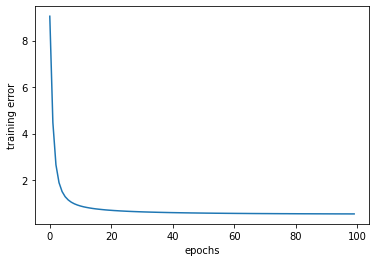

In [126]:
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('training error')

In [99]:
model.evaluate([test['cust'], test['pd_nm']], test['ratings'])

24740/24740 [==============================] - 23s 915us/step - loss: 4.4389 - mse: 4.4389


[4.43890905380249, 4.43890905380249]

In [100]:
predictions = model.predict([test['cust'].head(10), test['pd_nm'].head(10)])

for p, t in zip(predictions, test['ratings'].values[:10]):
    print(p, t)

[1.2760278] 1.7000000000000002
[9.105636] 9.3
[8.163997] 9.0
[8.996129] 9.6
[4.880432] 4.8
[9.456006] 9.5
[1.9414806] 1.9
[5.556103] 6.0
[9.899122] 9.5
[9.820293] 9.8


In [101]:
test.head(10)

,cust,pd_nm,ratings
441612,7162,1104,1.7
1290402,190,275,9.3
1271335,8000,275,9.0
3253707,13516,1470,9.6
2657189,20880,1765,4.8
3255255,6499,1470,9.5
2515769,13510,444,1.9
2275689,19736,1501,6.0
2008513,1215,16,9.5
182566,887,325,9.8


### 랜덤으로 넣기

In [124]:
test_1 = pd.DataFrame({'cust':[190],
                       'pd_nm':[1127]
                      })


In [125]:
predictions = model.predict([test_1['cust'], test_1['pd_nm']])
predictions

array([[6.0680327]], dtype=float32)

In [116]:
df[df['cust'] == 190]

,Unnamed: 0,cust,cop_c,br_c,pd_c,de_hr,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,ratings
5000,5005,190,A01,37,PD0290,15,1,391,12,남성의류상의,2.3
67827,68005,190,A01,37,PD0900,14,1,219,31,기타아웃도어/레저,0.0
85710,85926,190,A01,37,PD0949,12,1,1135,33,여성의류상의,9.8
85711,85927,190,A01,37,PD0949,12,1,1135,33,여성의류상의,8.7
176882,177407,190,A01,37,PD0777,15,1,325,28,남성스포츠화,5.4
...,...,...,...,...,...,...,...,...,...,...,...
3793194,3806020,190,A02,136,PD1426,21,1,999,48,열매채소,7.5
3793626,3806453,190,A02,136,PD1426,15,1,999,48,열매채소,7.5
3802556,3815411,190,A02,136,PD0879,14,1,616,30,밀폐/보관용기,2.5
3802820,3815675,190,A02,136,PD0879,21,1,616,30,밀폐/보관용기,2.5


In [119]:
df_04[df_04['clac_mcls_nm'] == '여성의류상의']

,pd_c,pd_nm,clac_hlv_nm,clac_mcls_nm
948,PD0949,1182,여성의류,여성의류상의
949,PD0950,1104,여성의류,여성의류상의
950,PD0951,1127,여성의류,여성의류상의
951,PD0952,1124,여성의류,여성의류상의
952,PD0953,1089,여성의류,여성의류상의
953,PD0954,1137,여성의류,여성의류상의
954,PD0955,1138,여성의류,여성의류상의


### DNN

In [49]:
product_input = Input(shape=(1,), name='product_input_layer')
user_input = Input(shape=(1,), name='user_input_layer')
weather_input = Input(shape=(1,), name='weather_input_layer')
time_input = Input(shape=(1,), name='time_input_layer')

product_embedding_layer = Embedding(number_of_unique_product_id + 1, 100, name='product_embedding_layer')
user_embedding_layer = Embedding(number_of_unique_user + 1, 100, name='user_embedding_layer')
weather_embedding_layer = Embedding(number_of_unique_weather + 1, 100, name='weather_embedding_layer')
time_embedding_layer = Embedding(number_of_unique_time + 1, 50, name='time_embedding_layer')

product_vector_layer = Flatten(name='product_vector_layer')
user_vector_layer = Flatten(name='user_vector_layer')
weather_vector_layer = Flatten(name='weather_vector_layer')
time_vector_layer = Flatten(name='time_vector_layer')

concate_layer = Concatenate()

dense_layer1 = Dense(512, activation='relu')
dense_layer2 = Dense(256, activation='relu')
dense_layer3 = Dense(128, activation='relu')
dense_layer4 = Dense(32, activation='relu')

result_ratings_layer = Dense(1)

In [51]:
product_embedding = product_embedding_layer(product_input)
user_embedding = user_embedding_layer(user_input)
weather_embedding = weather_embedding_layer(weather_input)
time_embedding = time_embedding_layer(time_input)

product_vector = product_vector_layer(product_embedding)
user_vector = user_vector_layer(user_embedding)
weather_vector = weather_vector_layer(weather_embedding)
time_vector = time_vector_layer(time_embedding)

concat = concate_layer([product_vector, user_vector, weather_vector, time_vector])
dense1 = dense_layer1(concat)
dense2 = dense_layer2(dense1)
dense3 = dense_layer3(dense2)
dense4 = dense_layer4(dense3)

result_ratings = result_ratings_layer(dense4)

model = Model(inputs=[user_input, product_input, weather_input, time_input], outputs=result_ratings)

In [52]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 product_input_layer (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                               
                                                                                                  
 user_input_layer (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 weather_input_layer (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                               
                                                                                            

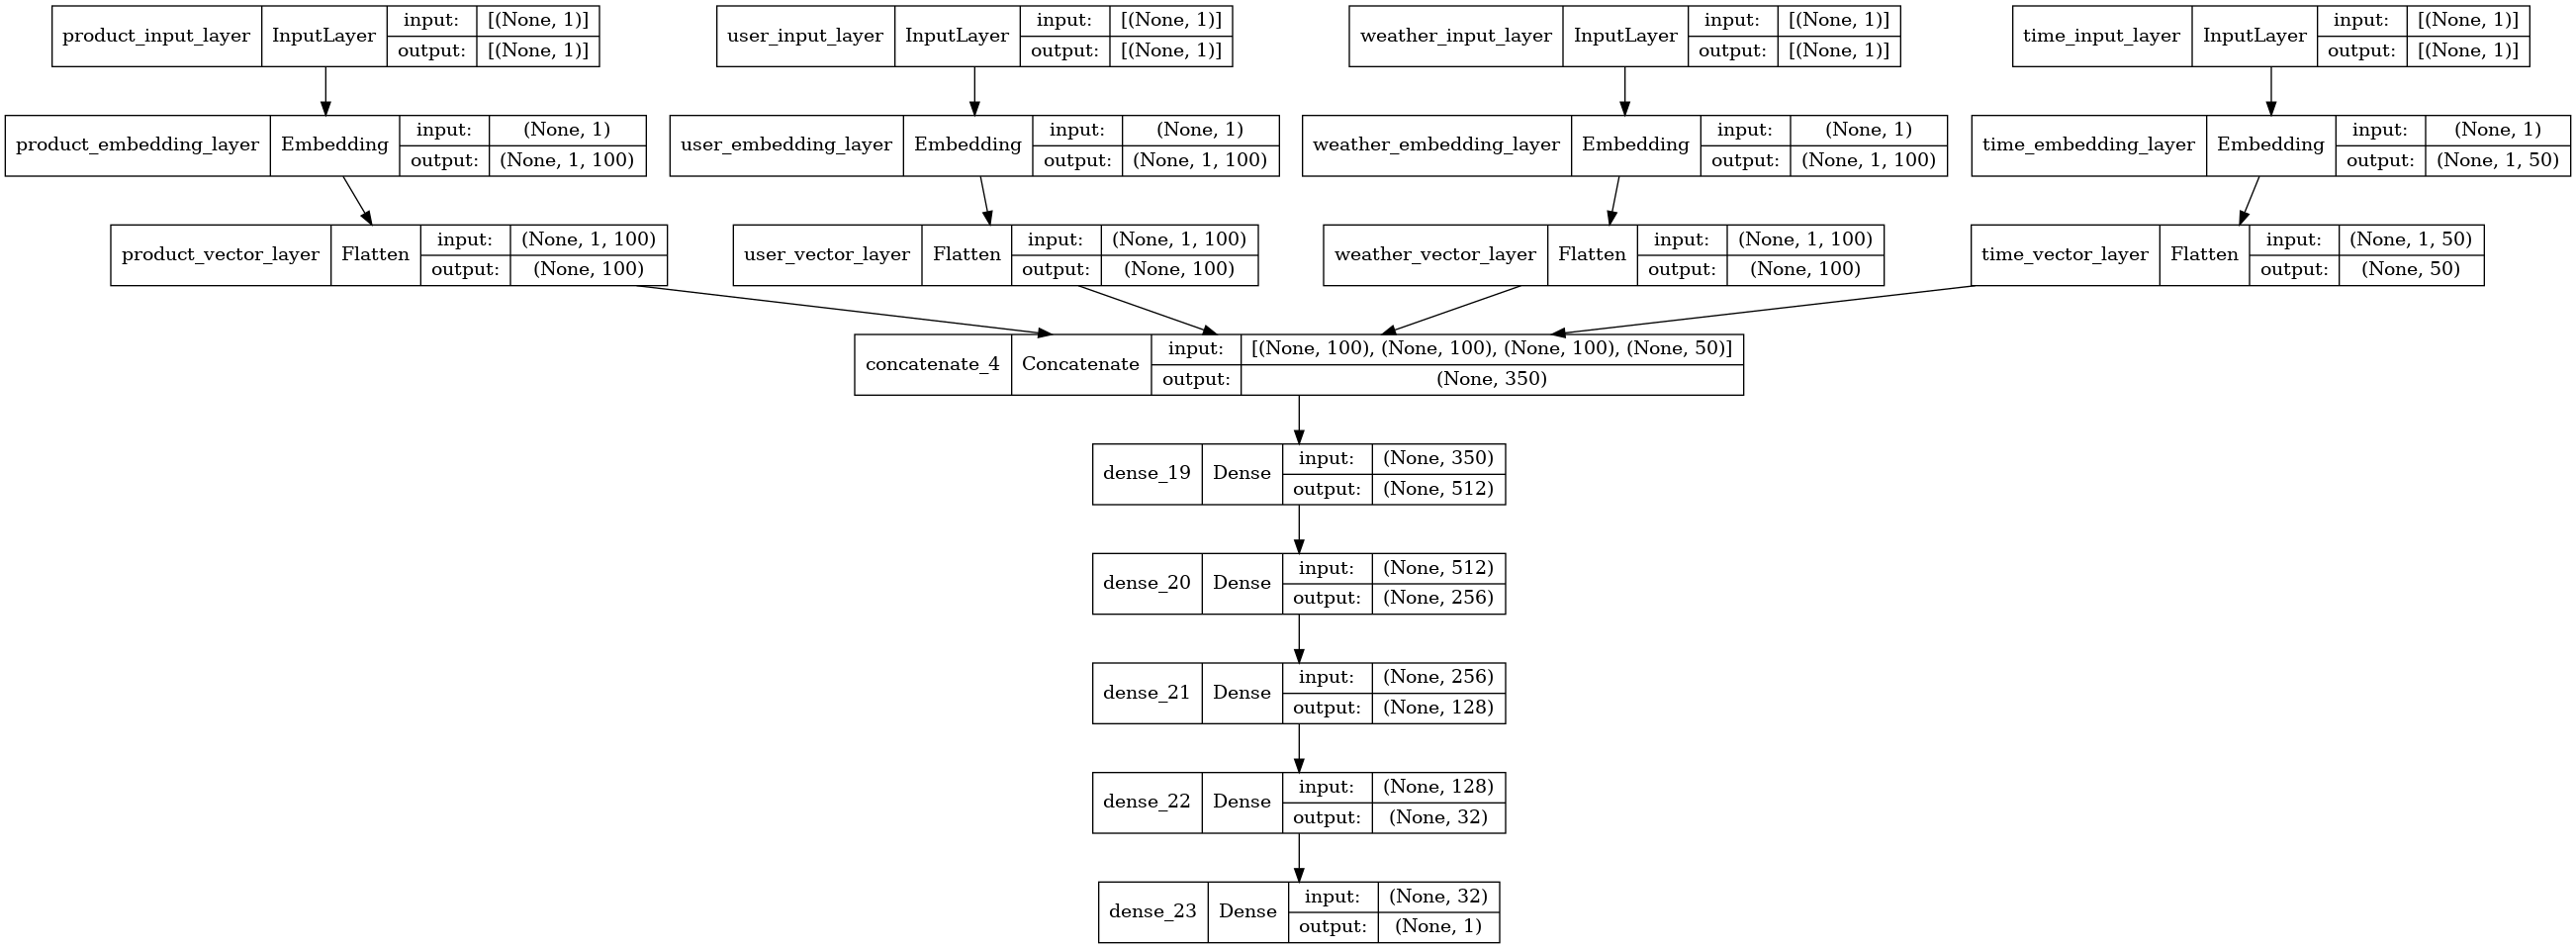

In [53]:
plot_model(model, show_shapes=True)

In [55]:
model.compile(loss = 'mse', optimizer='adam', metrics=['mse'])

In [56]:
history = model.fit([train['cust'], train['pd_nm'], train['평균기온'], train['de_dt']], train['ratings'], epochs=30, batch_size=256, validation_split=0.2, verbose=1)

Epoch 1/30
9850/9850 [==============================] - 35s 3ms/step - loss: 7.7635 - mse: 7.7635 - val_loss: 5.2041 - val_mse: 5.2041
Epoch 2/30
9850/9850 [==============================] - 34s 3ms/step - loss: 3.5386 - mse: 3.5386 - val_loss: 3.5605 - val_mse: 3.5605
Epoch 3/30
9850/9850 [==============================] - 34s 3ms/step - loss: 2.0163 - mse: 2.0163 - val_loss: 2.9451 - val_mse: 2.9451
Epoch 4/30
9850/9850 [==============================] - 34s 3ms/step - loss: 1.3413 - mse: 1.3413 - val_loss: 2.6675 - val_mse: 2.6675
Epoch 5/30
9850/9850 [==============================] - 34s 3ms/step - loss: 0.9873 - mse: 0.9873 - val_loss: 2.4870 - val_mse: 2.4870
Epoch 6/30
9850/9850 [==============================] - 34s 3ms/step - loss: 0.7805 - mse: 0.7805 - val_loss: 2.3888 - val_mse: 2.3888
Epoch 7/30
9850/9850 [==============================] - 34s 3ms/step - loss: 0.6474 - mse: 0.6474 - val_loss: 2.3087 - val_mse: 2.3087
Epoch 8/30
9850/9850 [==============================] -

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()